In [44]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [45]:
df = pd.read_csv('building-permits.csv', parse_dates=['APPLICATION_START_DATE','ISSUE_DATE'])#, usecols = [0,1])#, skiprows = [606387,606391])

C:\Users\Michael\anaconda3\envs\vis\lib\site-packages\IPython\core\interactiveshell.py:3156: DtypeWarning: Columns (1,49,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Lets Look at the import for some basic investigation, Are our important columns workable?

In [46]:
print(df.iloc[0:2,5])
print(df.iloc[0:2,4])
print(df.shape)

0   2014-03-04
1   2013-12-19
Name: ISSUE_DATE, dtype: datetime64[ns]
0   2014-02-24
1   2013-11-18
Name: APPLICATION_START_DATE, dtype: datetime64[ns]
(606390, 125)


In [47]:
df['APPLICATION_START_DATE'].describe()

C:\Users\Michael\anaconda3\envs\vis\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                  605890
unique                   5638
top       2019-08-01 00:00:00
freq                      457
first     2001-07-25 00:00:00
last      2019-12-04 00:00:00
Name: APPLICATION_START_DATE, dtype: object

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606390 entries, 0 to 606389
Columns: 125 entries, ID to :@computed_region_awaf_s7ux
dtypes: datetime64[ns](2), float64(28), int64(3), object(92)
memory usage: 578.3+ MB


Let's create a new column with the time required to get building permit issued.

In [49]:
df['PROCESSING_TIME'] = df['ISSUE_DATE'] - df['APPLICATION_START_DATE']
df['PROCESSING_TIME']

0          8 days
1         31 days
2         31 days
3          0 days
4          0 days
           ...   
606385   699 days
606386     0 days
606387     0 days
606388     0 days
606389     0 days
Name: PROCESSING_TIME, Length: 606390, dtype: timedelta64[ns]

The first data cleaning issue I have found is that we have rows withnegative time which cannot occur, I will remove them.
I believe there is more to clean but this will do for my preliminary result

In [50]:
print(min(df['PROCESSING_TIME']))

-2876 days +00:00:00


In [51]:
df =  df[['APPLICATION_START_DATE','ISSUE_DATE', 'PROCESSING_TIME']]
df.head()

,APPLICATION_START_DATE,ISSUE_DATE,PROCESSING_TIME
0,2014-02-24,2014-03-04,8 days
1,2013-11-18,2013-12-19,31 days
2,2013-11-18,2013-12-19,31 days
3,2017-01-25,2017-01-25,0 days
4,2007-02-15,2007-02-15,0 days


In [52]:
df.dtypes

APPLICATION_START_DATE     datetime64[ns]
ISSUE_DATE                 datetime64[ns]
PROCESSING_TIME           timedelta64[ns]
dtype: object

In [53]:
df = df[df['PROCESSING_TIME'] >= dt.timedelta(days=0)]
df

,APPLICATION_START_DATE,ISSUE_DATE,PROCESSING_TIME
0,2014-02-24,2014-03-04,8 days
1,2013-11-18,2013-12-19,31 days
2,2013-11-18,2013-12-19,31 days
3,2017-01-25,2017-01-25,0 days
4,2007-02-15,2007-02-15,0 days
...,...,...,...
606385,2004-06-18,2006-05-18,699 days
606386,2018-11-29,2018-11-29,0 days
606387,2015-05-20,2015-05-20,0 days
606388,2018-08-06,2018-08-06,0 days


In [54]:
min(df['PROCESSING_TIME'])  # negative values removed

Timedelta('0 days 00:00:00')

Now I can group this by dates and look at the data soon.  I am using an aggregate function looking at each application start date.  I am fining the mean processing time if a project was submitted on eachc day.

In [55]:
# df = df.groupby('APPLICATION_START_DATE')['PROCESSING_TIME'].mean(numeric_only=False)
# df

S = df.groupby('APPLICATION_START_DATE')['PROCESSING_TIME'].mean(numeric_only=False)
S


APPLICATION_START_DATE
2001-07-25          2162 days 00:00:00
2001-07-26          2172 days 00:00:00
2001-07-27          2171 days 00:00:00
2001-07-30          2168 days 00:00:00
2001-07-31          2231 days 00:00:00
                        ...           
2019-11-29             0 days 00:00:00
2019-11-30             0 days 00:00:00
2019-12-02   0 days 04:37:53.684210526
2019-12-03   0 days 02:17:29.246231155
2019-12-04             0 days 00:00:00
Name: PROCESSING_TIME, Length: 5638, dtype: timedelta64[ns]

In [56]:
S.describe()

count                           5638
mean     138 days 23:56:16.241617788
std      422 days 01:26:53.776888880
min                  0 days 00:00:00
25%        7 days 04:52:14.117647058
50%       14 days 03:56:34.162335065
75%       25 days 06:37:45.769320027
max               4114 days 00:00:00
Name: PROCESSING_TIME, dtype: object

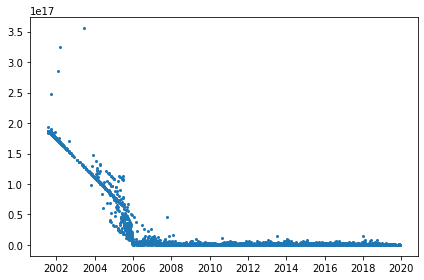

In [77]:
# p = plt.plot(S.index, S.values)
plt.plot_date(S.index, S.values,markersize=2)
plt.show()

looking at this we can gain some information, I would like to put a regression line on this
My initial hypothesis was that permit processing time is increasing over time, looks to be untrue.
What I do see that we can refine later to get a clearer picture
   1  Looks like there was a change in 2008, not suprising
   2  My guess is that the type of projects changed, many more over the counter permits for solar panels etc
       and less for building construction, get lots of zeros in the data.
   3  It is odd that in pre 2008 years, there is a clear line in the data, how could that be?

1
[-5.86082569e-04  4.43220456e+00]


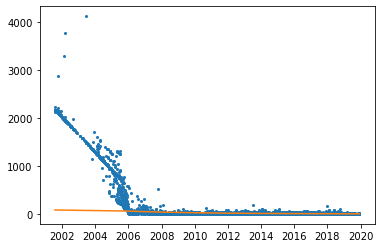

In [85]:
index2 = range(0,5638)
data2 = (S.values / np.timedelta64(1, 'D')).astype(int)
data2 += 1
S2 = pd.Series(index=index2, data=data2)

# I have all numbers in this Series S2 now
# I want to add one to all values  <--------------DONE
print(min(S2.values))

# Now do some curve fitting
fit = np.polyfit(S2.index, np.log(S2.values), 1)
print(fit)


# Plotting
plt.plot_date(S.index, S2.values,markersize=2)
plt.plot(S.index, np.exp(fit[1]) * (np.exp(fit[0])**S2.index) )
plt.show()

# That curve I fitted does not look very good, I am rushing.  Leave it for now,
# I have more data work that is more important now.

My task is to fix this before I send it to Eleanor,  I am trying to do an exponential regression, but I have zeros in my response (Processing_time).  I will add 1 to each value to remove any zeros and see what happens, seems janky but will get something.

[-0.23106309  5.54553313]


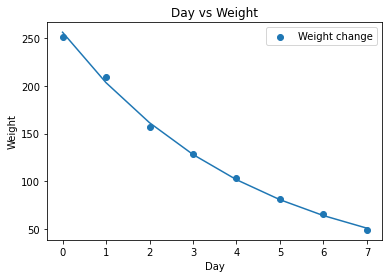

In [73]:
#------------------------------------------  Example Exponential Regression
day = np.arange(0,8)
weight = np.array([251,209,157,129,103,81,66,49])
fit = np.polyfit(day, np.log(weight), 1)
print(fit)
plt.scatter(day,weight,label='Weight change')

plt.plot(day, np.exp(fit[1]) * (np.exp(fit[0])**day) )
plt.title("Day vs Weight")
plt.xlabel('Day')
plt.ylabel('Weight')
plt.legend()
plt.show()